In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
from tqdm import tqdm_notebook
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA


In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    """
    Класс реализует разбор предложений на слова и построение индекса слов
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
!tail rus_eng_small.txt

она экономически независима от своих родителей .	she is economically independent of her parents .
она направила наши усилия в нужном направлении .	she steered our efforts in the right direction .
на этом заводе производят телевизоры .	they are manufacturing tv sets in this factory .
она всегда жалуется из за моей маленькой зарплаты .	she is always complaining about my small salary .
они стоят там и едят чипсы .	they are standing there and eating potato chips .
мне не удаётся скомпилировать эту программу .	i m having some problems compiling this software .
она улыбнулась в ответ на его нежный взгляд .	she smiled in response to his affectionate glance .
она проводит каждое воскресенье со своей бабушкой .	she spends time with her grandmother every sunday .
каждую субботу после обеда она играет в теннис .	she spends every saturday afternoon playing tennis .
после аварии она перестала бывать на людях .	she stopped appearing in public after her accident .


In [6]:
def readLangs():
    """
    Загрузка параллельного корпуса
    """
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open('rus_eng_small.txt') as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [7]:
def prepareData():
    """
    Чтение корпуса и инициализация словарей
    """
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...



Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['вы опоздали на полчаса .', 'you re thirty minutes late .']


In [8]:
def indexesFromSentence(lang, sentence):
    """
    Предложение в последовательность индексов слов
    """
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    """
    Предложение в pytorch тензор
    """
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    """
    Пара параллельных предложений во входной и целевой тензоры
    """
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [9]:
class EncoderRNN(nn.Module):
    """
    Модуль рекуррентного энкодера входного предложения
    """
    def __init__(self, input_size, nlayers, hidden_size):
        """
        :param input_size - размер словаря входных текстов
        :param nlayers - число рекуррентных слоев
        :param hidden_size - размер вектора состояния рекуррентного слоя
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        """
        :param x: [T,B] - входной тензор размерностью timestep на batch
        :param hidden - состояние рнн слоя
        :return output: [T,B,C], hidden - С=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        """Инициализируем состояние LSTM нулями"""
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

In [10]:
class DecoderRNN(nn.Module):
    """
    Модуль рекуррентного декодера
    """
    def __init__(self, hidden_size, nlayers, output_size):
        """
        :param hidden_size - размер вектора состояния рекуррентного слоя
        :param nlayers - число рекуррентных слоев
        :param output_size - размер словаря выходных текстов
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, hidden, _):
        """
        :param x: [T,B] - входной тензор размерностью timestep на batch
        :param hidden - состояние рнн слоя
        :return output: [T,B,C], hidden - С=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        logits = self.out(output)
        output = self.softmax(logits)
        return output, hidden, None

    def initHidden(self):
        """Инициализируем состояние LSTM нулями"""
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

In [28]:
class AttnDecoder(nn.Module):
    """
    Декодер с механизмом внимания dot-product attention
    T1 - шаги входной последовательности
    T2 - шаги выходной последовательности
    """
    def __init__(self, hidden_size, nlayers, output_size):
        """
        :param hidden_size - размер вектора состояния рекуррентного слоя
        :param nlayers - число рекуррентных слоев
        :param output_size - размер словаря выходных текстов
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, hidden, encoder_outputs):
        """
        :param x: [T2,B] - входной тензор с предыдущими словами размерностью timestep на batch
        :param hidden [1, B, C] - состояние рнн слоя
        :param encoder_outputs [T1,B,C] - выходы всех шагов энкодера
        :return output: [T2,B,C], hidden - С=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x) # [T2,B,C]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B,T1,C]
        outputs = []
        
        for i in range(x.size(0)):
            h_t = hidden[0].transpose(0, 1).transpose(1, -1) # [B, C, 1]

            context, attn_weights = self.attention(encoder_outputs, h_t)
        
            e = embedded[i].unsqueeze(0)
            output = torch.cat((e, context), dim=-1) # [[B,1,C];[B,1,C]] -> [B,1,C*2]
            output = self.attn_combine(output).transpose(0,1) # [B,1,C*2] * [C*2,C] = [B,1,C] -transpose-> [1,B,C]
            output = F.relu(output)
            output, hidden = self.rnn(output, hidden)

            logits = self.out(output)
            output = F.log_softmax(logits, dim=-1)
            outputs.append(output)
            
        output = torch.cat(outputs, dim=0)
        return output, hidden, attn_weights

    def attention(self, encoder_outputs, h):
        # bmm is the batch matrix multiplication. 
        # The first dimension of arguments is the batch dimension and should be the same
        # [B,T1,C]x[B,C,1] -> B [T1,C]x[C,1] = [B,T1,1]
        attn_weights = F.softmax(torch.bmm(encoder_outputs, h), dim=-2)
        
        context = last_hidden.unsqueeze(1)
        context = F.tanh(self.Wa(torch.cat((context, encoder_outputs), 1)))

        # Для каждой позиции выхода веса содержат значения для всех позиций входа T1
        # В таком случае взвешенная сумма может быть посчитана за одно матричное умножение
        # [B,1,T1]x[B,T1,C] -> B [1,T1]x[T1,C] = [B, 1, C]
        context = context.bmm(self.va.unsqueeze(2)).squeeze(-1)
        # на выходе имеем вектор контекста размерностью C для каждой позиции выхода t2
        return context, attn_weights

SyntaxError: invalid syntax (<ipython-input-28-c3adeab2287f>, line 66)

In [29]:
def train(input_tensor, target_tensor, encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    """
    Прогоняем forward и backward pass на одном батче
    """
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden # STATE TRANSFER
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [30]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [39]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [40]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    """
    Цикл тренировки
    """
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for i in range(1, n_iters + 1):
        training_pair = training_pairs[i - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        if i > n_iters / 2:
            teacher_forcing_ratio = (n_iters - i) / n_iters
        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if i % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, i / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, i, i / n_iters * 100, print_loss_avg))

        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses);

In [41]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Цикл тестирования
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [42]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [43]:
n_iters=40000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [44]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words).to(device)

In [45]:
teacher_forcing_ratio = 1.
learning_rate=0.001
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

train attention seq2seq
0m 37s (- 11m 57s) (2000 5%) 2.9981
1m 14s (- 11m 8s) (4000 10%) 2.4964
1m 57s (- 11m 3s) (6000 15%) 2.2657
2m 49s (- 11m 16s) (8000 20%) 2.1277
3m 41s (- 11m 4s) (10000 25%) 2.0322
4m 35s (- 10m 41s) (12000 30%) 1.8784
5m 18s (- 9m 52s) (14000 35%) 1.8685
5m 56s (- 8m 54s) (16000 40%) 1.8086
6m 47s (- 8m 18s) (18000 45%) 1.7346
7m 42s (- 7m 42s) (20000 50%) 1.6439
8m 21s (- 6m 50s) (22000 55%) 1.6125
8m 58s (- 5m 59s) (24000 60%) 1.5398
9m 37s (- 5m 10s) (26000 65%) 1.5019
10m 15s (- 4m 23s) (28000 70%) 1.4855
10m 54s (- 3m 38s) (30000 75%) 1.4373
11m 33s (- 2m 53s) (32000 80%) 1.4280
12m 11s (- 2m 9s) (34000 85%) 1.4399
12m 48s (- 1m 25s) (36000 90%) 1.3764
13m 25s (- 0m 42s) (38000 95%) 1.3261
14m 2s (- 0m 0s) (40000 100%) 1.2642


<Figure size 432x288 with 0 Axes>

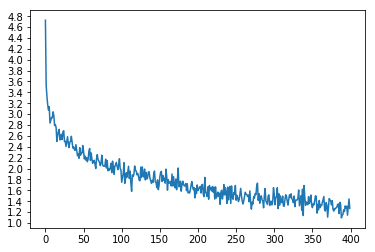

In [46]:
print('train attention seq2seq')
run_training(encoder, decoder, n_iters, print_every=2000)

train attention seq2seq
0m 35s (- 11m 13s) (2000 5%) 1.2117
1m 12s (- 10m 49s) (4000 10%) 1.2236
2m 4s (- 11m 48s) (6000 15%) 1.1711
2m 59s (- 11m 59s) (8000 20%) 1.1483
3m 52s (- 11m 38s) (10000 25%) 1.1527
4m 33s (- 10m 37s) (12000 30%) 1.0338
5m 8s (- 9m 33s) (14000 35%) 1.0775
6m 0s (- 9m 1s) (16000 40%) 1.0789
6m 52s (- 8m 23s) (18000 45%) 1.0484
7m 33s (- 7m 33s) (20000 50%) 0.9983
8m 8s (- 6m 39s) (22000 55%) 1.0133
8m 41s (- 5m 47s) (24000 60%) 0.9542
9m 20s (- 5m 1s) (26000 65%) 0.9424
10m 1s (- 4m 17s) (28000 70%) 0.9491
10m 33s (- 3m 31s) (30000 75%) 0.9108
11m 6s (- 2m 46s) (32000 80%) 0.9325
11m 47s (- 2m 4s) (34000 85%) 0.9242
12m 23s (- 1m 22s) (36000 90%) 0.9046
12m 57s (- 0m 40s) (38000 95%) 0.8766
13m 31s (- 0m 0s) (40000 100%) 0.8365


<Figure size 432x288 with 0 Axes>

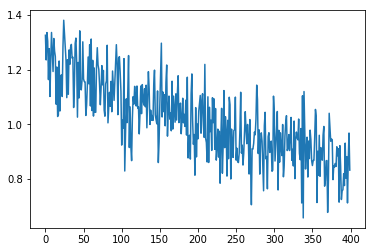

In [47]:
print('train attention seq2seq')
run_training(encoder, decoder, n_iters, print_every=2000)

In [48]:
evaluate_randomly(encoder, decoder)

> тебе почти тридцать .
= you re almost thirty .
< you re almost thirty .

> я не собираюсь его читать .
= i m not going to read it .
< i m not going to read it .

> я рад, что мы пришли к соглашению .
= i m glad we re in agreement .
< i m glad we won .

> ты всё время занят .
= you re busy all the time .
< you re always busy .

> я напугана .
= i m frightened .
< i m frightened .

> я устаю от этого .
= i m getting tired of it .
< i m getting tired of this .

> они ещё живы .
= they re still alive .
< they re still alive .

> я не наелась .
= i m still hungry .
< i m not hungry .

> он очень ревнует свою жену .
= he s very jealous of his wife .
< he s very popular .

> мы за ними следим .
= we re keeping an eye on them .
< we are on the same side .



torch.Size([1, 5, 1]) torch.Size([1, 5, 1])


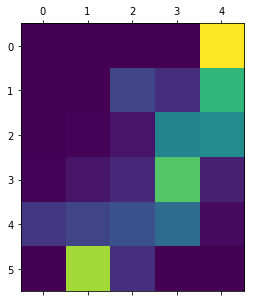

In [49]:
# давайте посмотрим на что похож attention
text = "я очень осторожна ."
output_words, attentions = evaluate(encoder, decoder, text)
print(attentions[0].size(),attentions[1].size())
attentions = torch.cat(attentions).squeeze().cpu()
plt.matshow(attentions.numpy());

In [50]:
def showAttention(input_sentence, output_words, attentions):
    """
    Выведем attention более детально, подписав токены в позициях входной и выходной последовательностей
    """
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split() +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    print(attentions.size())
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

torch.Size([6, 5])
input = я очень осторожна .
output = i m very careful .


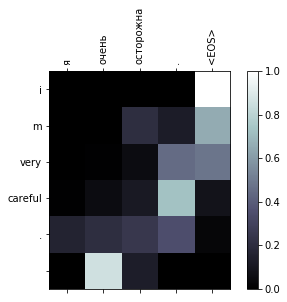

In [51]:
evaluateAndShowAttention("я очень осторожна .")

torch.Size([7, 5])
input = я бы выпил .
output = i m going to leave .


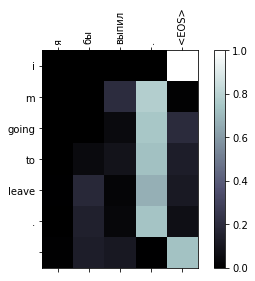

In [52]:
evaluateAndShowAttention("я бы выпил .")